In [ ]:
!apt-get install bedtools
!pip install pybedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  bedtools
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 577 kB of archives.
After this operation, 2,040 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bedtools amd64 2.26.0+dfsg-5 [577 kB]
Fetched 577 kB in 1s (616 kB/s)
Selecting previously unselected package bedtools.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../bedtools_2.26.0+dfsg-5_amd64.deb ...
Unpacking bedtools (2.26.0+dfsg-5) ...
Setting up bedtools (2.26.0+dfsg-5) ...
     |████████████████████████████████| 12.5MB 327kB/s 
     |████████████████████████████████| 10.0MB 39.2MB/s 
  Created wheel for pybedtools: filename=pybedtools-0.8.1-cp36-cp36m-linux_x86_64.whl size=13603771 sha256=2dada2bb3f33aaff3c136642870e50750825d37c67c3170627d5e019091fc0c8
  

In [ ]:
from google.colab import files

uploaded = files.upload()

fnam = []

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  fnam.append(fn)

Saving BAF170.bed to BAF170.bed
Saving BRG1.bed to BRG1.bed
Saving H3K4me3.bed to H3K4me3.bed
User uploaded file "BAF170.bed" with length 729418 bytes
User uploaded file "BRG1.bed" with length 354667 bytes
User uploaded file "H3K4me3.bed" with length 1737992 bytes


In [ ]:
fnam=['BAF170.bed','BRG1.bed','H3K4me3.bed']

In [ ]:
import pybedtools as pbt
import itertools

In [ ]:
def sortall(fname):
  sortedfiles = {}
  for fn in fname:
    sortedfiles[fn.split('.')[0]] = pbt.BedTool(fn).sort()
  return sortedfiles

In [ ]:
sortedfiles = sortall(fname=fnam)
print(sortedfiles)

{'BAF170': <BedTool(/tmp/pybedtools.gmb2g7z2.tmp)>, 'BRG1': <BedTool(/tmp/pybedtools.a7hnyor4.tmp)>, 'H3K4me3': <BedTool(/tmp/pybedtools.meorprpc.tmp)>}


In [ ]:
def multiple_intersect(sortedfiles):
  x = pbt.BedTool()
  fnatt = []
  for fi in sortedfiles.values():
    fnatt.append(fi.fn)
  x = x.multi_intersect(i=fnatt)
  return x

In [ ]:
intersect_file = multiple_intersect(sortedfiles)
intersect_file.head()

chr1	712415	716207	1	3	0	0	1
 chr1	760606	763901	1	3	0	0	1
 chr1	824926	825205	1	3	0	0	1
 chr1	825818	825992	1	3	0	0	1
 chr1	826086	826228	1	3	0	0	1
 chr1	839984	841402	1	3	0	0	1
 chr1	842320	842596	1	3	0	0	1
 chr1	852150	852301	1	3	0	0	1
 chr1	852496	852779	1	3	0	0	1
 chr1	855219	855445	1	3	0	0	1
 

In [ ]:
def parse_file(intersect_file,no_of_files):
  subset = {}
  for k in range(2,no_of_files+1):
    for combo in itertools.combinations(range(1,no_of_files+1),k):
      score_str = str(combo).replace(" ","")[1:-1]
      subset[score_str] = intersect_file.filter(lambda b: b.score == score_str).saveas('inter'+str(combo)+'.bed')
  return subset

In [ ]:
 subset = parse_file(intersect_file,no_of_files=len(fnam))

In [ ]:
print(subset)

{'1,2': <BedTool(inter(1, 2).bed)>, '1,3': <BedTool(inter(1, 3).bed)>, '2,3': <BedTool(inter(2, 3).bed)>, '1,2,3': <BedTool(inter(1, 2, 3).bed)>}


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_intersection_regions(subset):
  y = []
  for f in subset.keys():
    y.append(len(subset[f]))
  ax = plt.bar(subset.keys(),y)

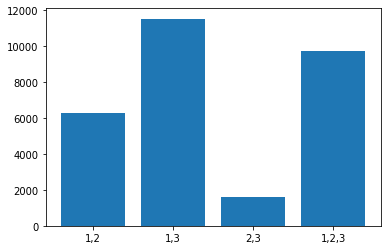

In [ ]:
plot_intersection_regions(subset)

In [ ]:
from google.colab import files

uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving gene.txt to gene.txt
User uploaded file "gene.txt" with length 53874878 bytes


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
gene = pd.read_csv("gene.txt",sep = "\t")
gene.head()

,bin,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames
0,0,NM_001276352.2,chr1,-,67092164,67134970,67093579,67127240,9,"67092164,67096251,67103237,67111576,67115351,6...","67093604,67096321,67103382,67111644,67115464,6...",0,C1orf141,cmpl,cmpl,"2,1,0,1,2,0,0,-1,-1,"
1,0,NM_001276351.2,chr1,-,67092164,67134970,67093004,67127240,8,"67092164,67095234,67096251,67115351,67125751,6...","67093604,67095421,67096321,67115464,67125909,6...",0,C1orf141,cmpl,cmpl,"0,2,1,2,0,0,-1,-1,"
2,0,NR_075077.2,chr1,-,67092164,67134970,67134970,67134970,10,"67092164,67096251,67103237,67111576,67113613,6...","67093604,67096321,67103382,67111644,67113756,6...",0,C1orf141,none,none,"-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,"
3,0,XM_011541469.1,chr1,-,67092175,67109072,67093004,67103382,5,"67092175,67095234,67096251,67103237,67109028,","67093604,67095421,67096321,67103382,67109072,",0,C1orf141,cmpl,cmpl,"0,2,1,0,-1,"
4,0,XM_011541467.1,chr1,-,67092175,67131183,67093004,67127240,9,"67092175,67095234,67096251,67103237,67111576,6...","67093604,67095421,67096321,67103343,67111644,6...",0,C1orf141,cmpl,cmpl,"0,2,1,0,1,2,0,0,-1,"


In [ ]:
gene = gene[["chrom","txStart","txEnd","strand","name2"]]
gene.head()

,chrom,txStart,txEnd,strand,name2
0,chr1,67092164,67134970,-,C1orf141
1,chr1,67092164,67134970,-,C1orf141
2,chr1,67092164,67134970,-,C1orf141
3,chr1,67092175,67109072,-,C1orf141
4,chr1,67092175,67131183,-,C1orf141


In [ ]:
gene.to_csv("gene_anno.bed",header = None,index= None,sep= '\t')

In [ ]:
def anno(file,dist) :
  genes = pbt.BedTool("gene_anno.bed")
  genes = genes.sort()
  nearby = file.closest(genes, d=True, stream= True).saveas("anno.bed")
  annot = pd.read_csv("anno.bed",sep = "\t",header= None)
  annot = annot[annot[annot.shape[1]-1] < dist]
  annot = annot.drop_duplicates()
  annot = annot.drop_duplicates([0,1,2])
  return annot

In [ ]:
 annot = anno(subset['1,2,3'],1000)

In [ ]:
annot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,chr1,998038,1000319,3,"1,2,3",1,1,1,chr1,998961,1001052,-,HES4,0
4,chr1,1239763,1245571,3,"1,2,3",1,1,1,chr1,1242447,1247218,-,C1QTNF12,0
9,chr1,1279155,1281987,3,"1,2,3",1,1,1,chr1,1274001,1279447,+,LINC01786,0
13,chr1,1509224,1511194,3,"1,2,3",1,1,1,chr1,1471731,1509466,+,ATAD3B,0
14,chr1,1689860,1690094,3,"1,2,3",1,1,1,chr1,1661477,1692795,-,SLC35E2B,0


(array([6414.,   13.,    7.,   20.,   20.,   23.,   15.,   17.,   23.,
          20.]),
 array([  0. ,  99.1, 198.2, 297.3, 396.4, 495.5, 594.6, 693.7, 792.8,
        891.9, 991. ]),
 <a list of 10 Patch objects>)

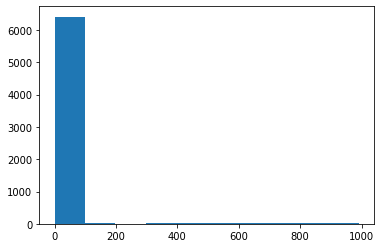

In [ ]:
plt.hist(annot[annot.shape[1]-1])

In [ ]:
ann = annot[annot.columns[-6:]]

In [ ]:
ann.columns = ["chrom","txStart","txEnd","strand","name","dist"]

In [ ]:
def new(tst,tend,strand,cutoff):
  if str(strand) == '+':
   start = tst-cutoff
  else:
    start = tend
  return start

In [ ]:
def neww(tst,tend,strand,cutoff):
  if str(strand) == "+":
   end = tst
  else:
    end = tend+cutoff
  return end

In [ ]:
ann['start'] = ann.apply(lambda x: new(tst=x['txStart'],tend=x['txEnd'],strand=x['strand'],cutoff=100),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
ann['end'] = ann.apply(lambda x: new(tst=x['txStart'],tend=x['txEnd'],strand=x['strand'],cutoff=100),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
ann.head()

,chrom,txStart,txEnd,strand,name,dist,start,end
1,chr1,998961,1001052,-,HES4,0,1001052,1001052
4,chr1,1242447,1247218,-,C1QTNF12,0,1247218,1247218
9,chr1,1274001,1279447,+,LINC01786,0,1273901,1273901
13,chr1,1471731,1509466,+,ATAD3B,0,1471631,1471631
14,chr1,1661477,1692795,-,SLC35E2B,0,1692795,1692795


In [ ]:
ann.columns

Index(['chrom', 'txStart', 'txEnd', 'strand', 'name', 'dist', 'start', 'end'], dtype='object')

In [ ]:
gene_list = ann['name'].values
ann = ann[["chrom","start","end"]]

In [ ]:
ann.head()

,chrom,start,end
1,chr1,1001052,1001052
4,chr1,1247218,1247218
9,chr1,1273901,1273901
13,chr1,1471631,1471631
14,chr1,1692795,1692795


In [ ]:
print(gene_list)

['HES4' 'C1QTNF12' 'LINC01786' ... 'PLXNB3' 'PDZD4' 'F8']


In [ ]:
ann.to_csv("seq_inp.bed",header = None,index= None,sep= '\t')

In [ ]:
from matplotlib_venn import venn2

In [ ]:
def plot_venn(list1,list2):
  venn2([set(list1),set(list2)])

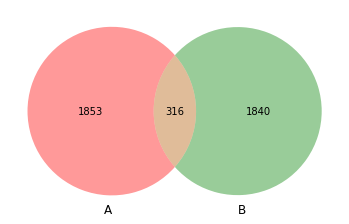

In [ ]:
plot_venn(list1,list2)

In [ ]:
!pip install gseapy

     |████████████████████████████████| 532kB 5.3MB/s 
     |████████████████████████████████| 235kB 10.5MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 153kB 10.9MB/s 
     |████████████████████████████████| 5.5MB 14.2MB/s 
     |████████████████████████████████| 163kB 38.9MB/s 
     |████████████████████████████████| 245kB 41.3MB/s 
  Created wheel for bioservices: filename=bioservices-1.7.11-cp36-none-any.whl size=236089 sha256=e8485d363b55a41a5d38555c26bf506e9959c388fc730f52320bb22194e4bdf2
  Stored in directory: /root/.cache/pip/wheels/60/6c/61/1e0bf60bbf1c01bebc0b36f25aa94a4028474203414ed4088d
  Created wheel for easydev: filename=easydev-0.11.0-cp36-none-any.whl size=64244 sha256=7e8ea84166f02724ae5221d1fb11a4af1cfb21d2eb6e3ea14e592951aaa7ffbc
  Stored in directory: /root/.cache/pip/wheels/17/69/b5/771949d8100a30aa33e4bc5d0ff77eced9063284891ce26898
  Created wheel for suds-jurko: filename=suds_jurko-0.6-cp36-none-any.whl size=4

In [ ]:
gene_sets=['KEGG_2016','KEGG_2013']

In [ ]:
def list_to_txt(glist):
  F = open('genelist.txt', 'w')
  for i in glist:
    F.write(str(i) + "\n")
  F.close()

In [ ]:
list_to_txt(gene_list)

In [ ]:
import gseapy as gp

In [ ]:
enr = gp.enrichr(gene_list='genelist.txt' ,
                 gene_sets=gene_sets ,
                 organism='Human',
                 description='test_name',
                 outdir='test/pathways',
                 cutoff=0.05
                )

In [ ]:
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Glyoxylate and dicarboxylate metabolism Homo s...,6/28,0.000011,0.002030,0,0,14.488544,165.303610,MDH1;AFMID;CAT;HYI;ACO1;MUT
1,KEGG_2016,Metabolic pathways Homo sapiens hsa01100,43/1239,0.000074,0.006735,0,0,1.995726,18.992907,LIPT1;FECH;NDUFB6;COX15;MTMR14;GBE1;ADK;SAT2;M...
2,KEGG_2016,Tyrosine metabolism Homo sapiens hsa00350,5/35,0.000461,0.028123,0,0,8.826577,67.806030,GSTZ1;ALDH1A3;FAHD1;FAH;ADH5
3,KEGG_2016,Carbon metabolism Homo sapiens hsa01200,7/113,0.005446,0.249134,0,0,3.502692,18.259384,ALDH6A1;MDH1;CAT;ACO1;MUT;ADH5;HIBCH
4,KEGG_2016,beta-Alanine metabolism Homo sapiens hsa00410,3/31,0.019935,0.623734,0,0,5.644297,22.098966,ALDH1A3;ALDH6A1;HIBCH


In [ ]:
from gseapy.plot import barplot

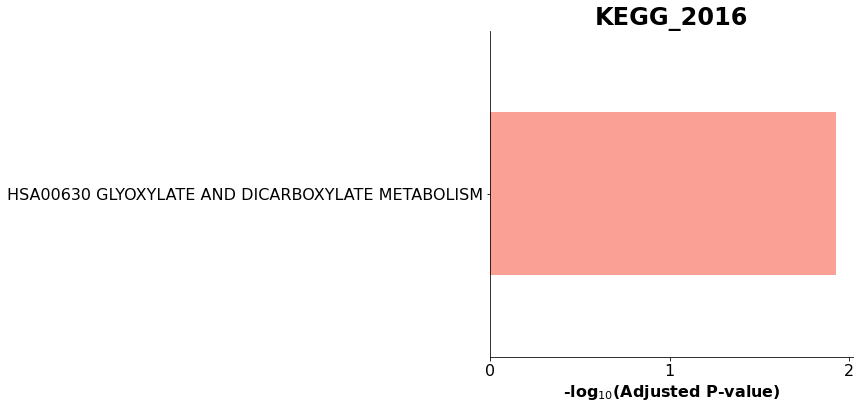

In [ ]:
barplot(enr.res2d,title='KEGG_2016',)

In [ ]:
!pip install -U motifscan

     |████████████████████████████████| 235kB 6.9MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
  Created wheel for motifscan: filename=motifscan-1.3.0-cp36-cp36m-linux_x86_64.whl size=64844 sha256=6c35928b76942094e646f8e76d7510b6f8e92f74ae08c7178c7431f06a5d0753
  Stored in directory: /root/.cache/pip/wheels/6e/9d/33/feddd3a71c3e47d5cf96b8a1c31fc7a4509c27cccfe3d8d529
Successfully built motifscan
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import subprocess

In [ ]:
a = pbt.BedTool("seq_inp.bed")

In [ ]:
a.sort().saveas("sequ_inp.bed")

<BedTool(sequ_inp.bed)>

In [ ]:
s=subprocess.check_output('motifscan genome --list-remote',shell=True).decode('utf-8')
s=str(s)
print(s)

hg38        	UCSC	Human Dec. 2013 (GRCh38/hg38) Genome at UCSC
hg19        	UCSC	Human Feb. 2009 (GRCh37/hg19) Genome at UCSC
hg18        	UCSC	Human Mar. 2006 (NCBI36/hg18) Genome at UCSC
hg17        	UCSC	Human May 2004 (NCBI35/hg17) Genome at UCSC
hg16        	UCSC	Human July 2003 (NCBI34/hg16) Genome at UCSC
mm39        	UCSC	Mouse Jun. 2020 (GRCm39/mm39) Genome at UCSC
mm10        	UCSC	Mouse Dec. 2011 (GRCm38/mm10) Genome at UCSC
mm9         	UCSC	Mouse July 2007 (NCBI37/mm9) Genome at UCSC
mm8         	UCSC	Mouse Feb. 2006 (NCBI36/mm8) Genome at UCSC
mm7         	UCSC	Mouse Aug. 2005 (NCBI35/mm7) Genome at UCSC
anoGam3     	UCSC	A. gambiae Oct. 2006 (AgamP3/anoGam3) Genome at UCSC
anoGam1     	UCSC	A. gambiae Feb. 2003 (IAGEC MOZ2/anoGam1) Genome at UCSC
apiMel2     	UCSC	A. mellifera Jan. 2005 (Baylor 2.0/apiMel2) Genome at UCSC
apiMel1     	UCSC	A. mellifera July 2004 (Baylor 1.2/apiMel1) Genome at UCSC
xenLae2     	UCSC	African clawed frog Aug. 2016 (Xenopus_laevis_v2/xenLae2

In [ ]:
m=subprocess.check_output('motifscan motif --list-remote',shell=True).decode('utf-8')
m=str(m)
print(m)

vertebrates_non-redundant	JASPAR2020_CORE
vertebrates_redundant    	JASPAR2020_CORE
plants_non-redundant     	JASPAR2020_CORE
plants_redundant         	JASPAR2020_CORE
insects_non-redundant    	JASPAR2020_CORE
insects_redundant        	JASPAR2020_CORE
nematodes_non-redundant  	JASPAR2020_CORE
nematodes_redundant      	JASPAR2020_CORE
fungi_non-redundant      	JASPAR2020_CORE
fungi_redundant          	JASPAR2020_CORE
urochordates_non-redundant	JASPAR2020_CORE
urochordates_redundant   	JASPAR2020_CORE



In [ ]:
#@title Choose genome and motif set
genome = 'hg38' #@param {type:"string"}
motif_set = 'vertebrates_non-redundant' #@param {type:"string"}
input_file = 'inpu_seq.bed' #@param {type:"string"}
output_dir = 'inpu_seq.bed' #@param {type:"string"}
print(genome,'\n',motif_set,'\n',input_file,'\n',output_dir)

In [ ]:
def motif_search(genome,motif_set,file,out_dir):
  flag = []
  ins_genome ='motifscan genome --install -n geno -r '+ str(genome)
  flag.append(subprocess.call(ss,shell=True))
  ins_motifset = 'motifscan motif --install -n moti -r '+str(motif_set)
  flag.append(subprocess.call(ss,shell=True))
  build_pwm ='motifscan motif --build vert -g geno'
  flag.append(subprocess.call(ss,shell=True))
  scan ='motifscan scan -i '+str(file)+' -g geno -m vert -o '+str(out_dir)
  flag.append(subprocess.call(ss,shell=True))
  return flag

In [ ]:
flag = motif_search(genome,motif_set,input_file,output_dir)

In [ ]:
!motifscan genome --install -n geno -r hg19

Installing genome assembly 'geno' into /root/.motifscan/genomes/geno
hg19.fa.gz: 100% 949M/949M [00:22<00:00, 42.4MB/s]
refGene.txt.gz: 100% 8.04M/8.04M [00:00<00:00, 14.0MB/s]
Calculating nucleotide frequencies of the genome background
Writing nucleotide frequencies
Updating the config file


In [ ]:
!motifscan motif --install -n moti -r vertebrates_non-redundant

Installing motif set 'moti' into /root/.motifscan/motifs/moti
Updating the config file


In [ ]:
!motifscan motif --build moti -g geno

Building motif set 'moti' for genome assembly 'geno'
Loading genome 'geno'
Loading motif PFMs set 'moti'
Converting motif PFMs to PWMs
Random sampling background sequences
Calculating background motif scores
^C


In [ ]:
!motifscan scan -i inpu_seq.bed -g geno -m moti -o outd

Running MotifScan 1.3.0
===== Loading data =====
Loading genome 'geno'
Loading motif PWMs set 'moti' under genome 'geno'
Traceback (most recent call last):
  File "/usr/local/bin/motifscan", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/motifscan/cli/main.py", line 593, in main
    args.func(args)
  File "/usr/local/lib/python3.6/dist-packages/motifscan/cli/scan.py", line 28, in run
    pwms = load_built_pwms(name=args.motif, genome=args.genome)
  File "/usr/local/lib/python3.6/dist-packages/motifscan/motif/__init__.py", line 374, in load_built_pwms
    raise PwmsFileNotFoundError(name, genome)
motifscan.exceptions.PwmsFileNotFoundError: No PWMs file for motif set 'moti' under genome geno
